# **1. Import Libraries**

In [ ]:
!pip install torchinfo
!pip install --upgrade albumentations
!pip install pytorch_msssim


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from pytorch_msssim import SSIM

import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go

import cv2
import albumentations as A
from PIL import Image

import os
import random
import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
from tensorboard.backend.event_processing import event_accumulator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()

Using device: cpu


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

#  **2. Prepare Data**



## 2.1. Download Dataset

In [ ]:
!gdown 1VCkl8rZTagEVBHXqCd7aOzF-AhMhFIbg

Downloading...
From (original): https://drive.google.com/uc?id=1VCkl8rZTagEVBHXqCd7aOzF-AhMhFIbg
From (redirected): https://drive.google.com/uc?id=1VCkl8rZTagEVBHXqCd7aOzF-AhMhFIbg&confirm=t&uuid=738c9598-d847-4401-b677-242b4b8424a9
To: /content/small_animal_dataset.zip
100% 176M/176M [00:01<00:00, 132MB/s]


In [ ]:
!unzip /content/small_animal_dataset.zip

Archive:  /content/small_animal_dataset.zip
replace animal_small_dataset/free-photo-of-close-up-of-squirrel-enjoying-a-nut-in-nature.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
len(os.listdir('/content/animal_small_dataset'))

2100

## 2.2. Data Augmentation

In [ ]:
def create_new_data_by_augmentation(input_dir, output_dir, augmentation, aug_amount):
    os.makedirs(output_dir, exist_ok=True)

    for filename in tqdm(os.listdir(input_dir)):
        img_path = os.path.join(input_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        output_original_path = os.path.join(output_dir, f"{filename}")
        cv2.imwrite(output_original_path, cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

        for i in range(aug_amount):
            augmented = augmentation(image=image)
            augmented_image = augmented["image"]

            output_path = os.path.join(output_dir, f"{filename.split('.')[0]}_aug_{i}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2GRAY))

    print(f"\nSaved path: {output_dir} with total {len(os.listdir(output_dir))} images.")

In [ ]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
])

input_dir = "/content/animal_small_dataset"
output_dir = "/content/new_dataset"

create_new_data_by_augmentation(input_dir, output_dir, augmentation, 0)

100%|██████████| 2100/2100 [00:20<00:00, 104.43it/s]


Saved path: /content/new_dataset with total 2100 images.


In [ ]:
def display_images_from_folder(folder_path, num_images=16, grid_size=(4, 4)):
    image_files = [i for i in os.listdir(folder_path)]

    image_files = image_files[:num_images]

    plt.figure(figsize=(12, 12))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


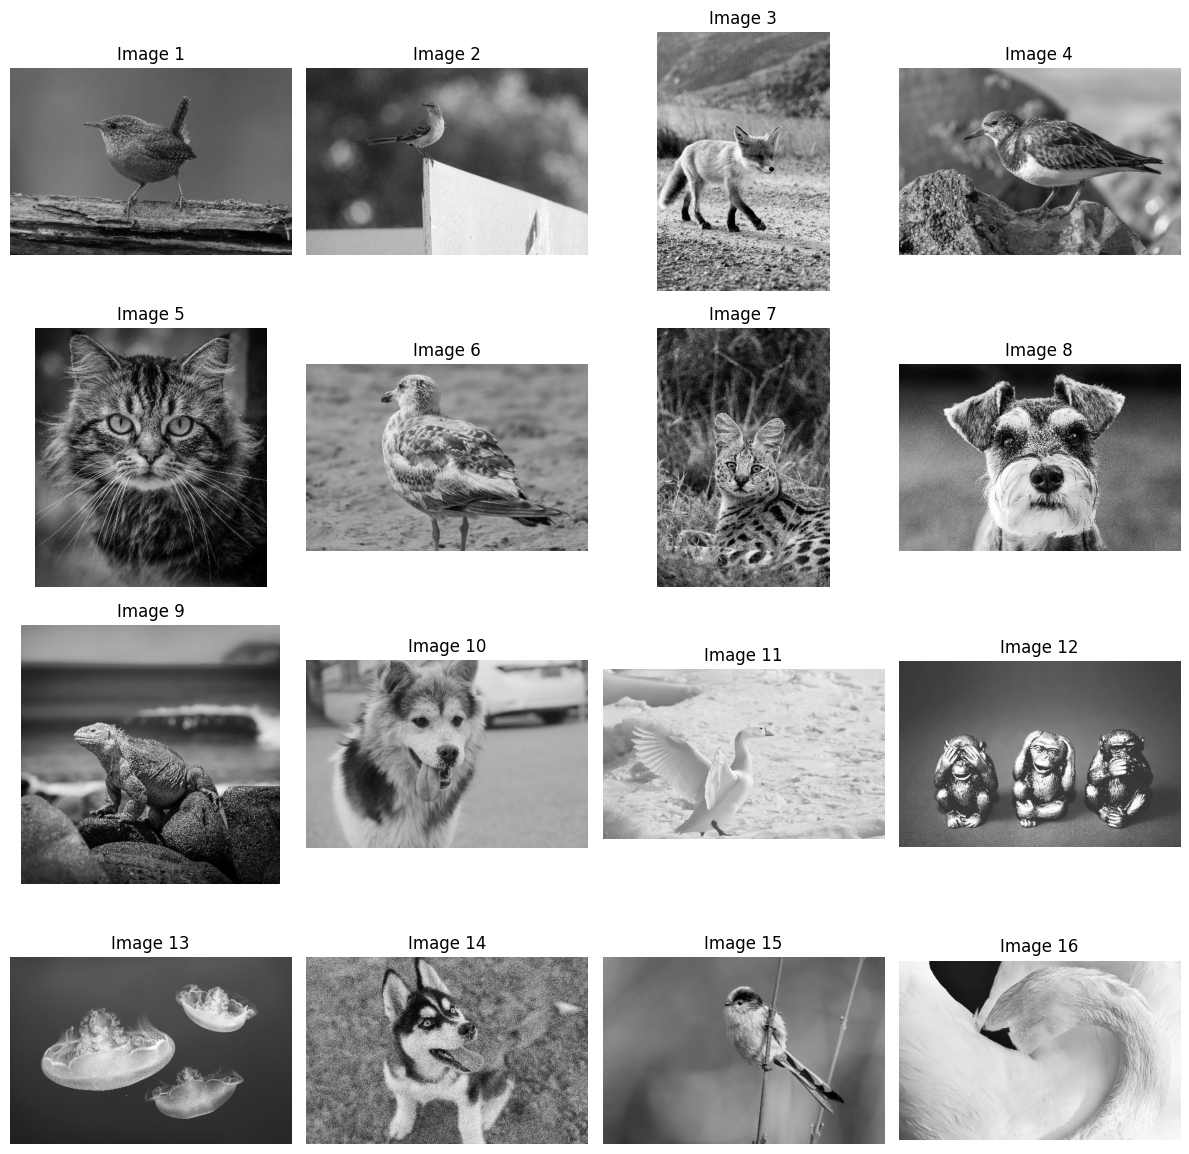

In [ ]:
display_images_from_folder(output_dir)


## 2.2. Build Dataset

In [ ]:
class DenoisingImageDataset(Dataset):
    def __init__(self, image_path_list, noise_factor=0.25, transform=None):
        self.sample_folder = image_path_list
        self.noise_factor = noise_factor
        self.transform = transform

    def __len__(self):
        return len(self.sample_folder)

    def __getitem__(self, idx):
        clean_img_path = self.sample_folder[idx]
        clean_img = Image.open(clean_img_path).convert('L')
        clean_img_tensor = transforms.ToTensor()(clean_img)

        noise = self.noise_factor * torch.randn_like(clean_img_tensor)
        noisy_img_tensor = clean_img_tensor + noise
        noisy_img_tensor = torch.clamp(noisy_img_tensor, 0.0, 1.0)

        if self.transform:
            noisy_img_tensor = self.transform(noisy_img_tensor)
            clean_img_tensor = self.transform(clean_img_tensor)

        return noisy_img_tensor, clean_img_tensor


## 2.3. Create DataLoader


In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    # transforms.ToTensor(),
])
batch_size = 512
noise_factor = 0.15

image_root_path = '/content/new_dataset'
image_path_list = [*map(lambda x: os.path.join(image_root_path, x), os.listdir(image_root_path))]

train_image_path_list = image_path_list[:int(len(image_path_list) * 0.9)]
val_image_path_list = image_path_list[int(len(image_path_list) * 0.1):]

train_dataset = DenoisingImageDataset(image_path_list=train_image_path_list, noise_factor=noise_factor, transform=transform)
val_dataset = DenoisingImageDataset(image_path_list=val_image_path_list, noise_factor=noise_factor, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


# **3. Build Model Architecture**


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, input_dims),
            nn.ReLU(),
        )

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
from torchinfo import summary

input_dims = 28 * 28
hidden_dims = 128
output_dims = 10

summary(DenoisingAutoencoder(input_dims, hidden_dims, output_dims).to(device), input_size=(batch_size, 1, 28, 28), row_settings=["var_names"])

Layer (type (var_name))                       Output Shape              Param #
DenoisingAutoencoder (DenoisingAutoencoder)   [512, 784]                --
├─Sequential (encoder)                        [512, 10]                 --
│    └─Linear (0)                             [512, 128]                100,480
│    └─ReLU (1)                               [512, 128]                --
│    └─Linear (2)                             [512, 128]                16,512
│    └─ReLU (3)                               [512, 128]                --
│    └─Linear (4)                             [512, 128]                16,512
│    └─ReLU (5)                               [512, 128]                --
│    └─Linear (6)                             [512, 128]                16,512
│    └─ReLU (7)                               [512, 128]                --
│    └─Linear (8)                             [512, 128]                16,512
│    └─ReLU (9)                               [512, 128]                --

# **4. Create Gradient Monitor**

In [ ]:
class GradientMonitor:
    def __init__(self, model):
        self.model = model
        self.gradients = {}
        self.hooks = []
        self._register_hooks()

    def _hook_fn(self, name):
        def hook(module, grad_input, grad_output):
            if grad_output and grad_output[0] is not None:
                self.gradients[name] = grad_output[0].norm().item()
            else:
                self.gradients[name] = 0.0
        return hook

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                hook = module.register_full_backward_hook(self._hook_fn(name))
                self.hooks.append(hook)

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def get_gradients(self):
        return self.gradients


# **5. Design Training Process**


## 5.1 Training and Evaluation Function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, writer, grad_monitor, max_grad_norm):
    metrics = {
        'loss': {'train': [], 'val': []},
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (noisy, clean) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            noisy = noisy.to(device)
            clean = clean.to(device)

            outputs = model(noisy)
            clean = clean.view(clean.size(0), -1)
            loss = criterion(outputs, clean)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        metrics['loss']['train'].append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy = noisy.to(device)
                clean = clean.to(device)

                clean = clean.view(clean.size(0), -1)
                outputs = model(noisy)
                loss = criterion(outputs, clean)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        metrics['loss']['val'].append(avg_val_loss)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        gradients = grad_monitor.get_gradients()
        for layer_name, grad_norm in gradients.items():
            print(f"\t{layer_name}: {grad_norm:.10f}")
            writer.add_scalar(f'Gradients/{layer_name}', grad_norm, epoch)

    print("Training complete.")
    return metrics

## 5.2 Model Setup

In [ ]:
criterion = nn.MSELoss()
num_epochs = 20

if not os.path.exists('gradient_plots'):
    os.makedirs('gradient_plots')

In [ ]:
autoencoder = DenoisingAutoencoder(input_dims, hidden_dims, output_dims).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
max_grad_norm = 1.0
current_time = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = f'runs/denoising_autoencoder_{current_time}'
writer = SummaryWriter(log_dir)

grad_monitor = GradientMonitor(autoencoder)


## 5.3. Training

In [ ]:
metrics = train_model(autoencoder, train_loader, val_loader, criterion, optimizer, device, num_epochs, writer, grad_monitor, max_grad_norm)
grad_monitor.remove_hooks()
writer.close()


Epoch 0/20: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Epoch [1/20], Train Loss: 0.2583, Val Loss: 0.2556
	decoder.14: 0.0016654480
	decoder.12: 0.0015458931
	decoder.10: 0.0008543474
	decoder.8: 0.0004454688
	decoder.6: 0.0002632376
	decoder.4: 0.0001391590
	decoder.2: 0.0000633767
	decoder.0: 0.0000358753
	encoder.14: 0.0000069201
	encoder.12: 0.0000030549
	encoder.10: 0.0000012758
	encoder.8: 0.0000006590
	encoder.6: 0.0000003098
	encoder.4: 0.0000001637
	encoder.2: 0.0000000749
	encoder.0: 0.0000000372


Epoch 1/20: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Epoch [2/20], Train Loss: 0.2509, Val Loss: 0.2438
	decoder.14: 0.0015792163
	decoder.12: 0.0024406458
	decoder.10: 0.0018122405
	decoder.8: 0.0012138706
	decoder.6: 0.0008946611
	decoder.4: 0.0006338727
	decoder.2: 0.0003934463
	decoder.0: 0.0002745732
	encoder.14: 0.0000778798
	encoder.12: 0.0000366227
	encoder.10: 0.0000187256
	encoder.8: 0.0000125505
	encoder.6: 0.0000078445
	encoder.4: 0.0000052569
	encoder.2: 0.0000032067
	encoder.0: 0.0000020980


Epoch 2/20: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Epoch [3/20], Train Loss: 0.2297, Val Loss: 0.1846
	decoder.14: 0.0014365760
	decoder.12: 0.0030757387
	decoder.10: 0.0029277815
	decoder.8: 0.0024878881
	decoder.6: 0.0022801110
	decoder.4: 0.0019916245
	decoder.2: 0.0015566249
	decoder.0: 0.0013621977
	encoder.14: 0.0004643263
	encoder.12: 0.0002301117
	encoder.10: 0.0001457789
	encoder.8: 0.0001198223
	encoder.6: 0.0000935526
	encoder.4: 0.0000764125
	encoder.2: 0.0000566931
	encoder.0: 0.0000457031


Epoch 3/20: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Epoch [4/20], Train Loss: 0.1582, Val Loss: 0.1409
	decoder.14: 0.0013455147
	decoder.12: 0.0036699960
	decoder.10: 0.0043691965
	decoder.8: 0.0044979076
	decoder.6: 0.0048671681
	decoder.4: 0.0050836112
	decoder.2: 0.0049806945
	decoder.0: 0.0051278947
	encoder.14: 0.0019956797
	encoder.12: 0.0010432866
	encoder.10: 0.0008095489
	encoder.8: 0.0007929742
	encoder.6: 0.0007515319
	encoder.4: 0.0007320110
	encoder.2: 0.0006539675
	encoder.0: 0.0006335530


Epoch 4/20: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]


Epoch [5/20], Train Loss: 0.1211, Val Loss: 0.1332
	decoder.14: 0.0008972457
	decoder.12: 0.0020360861
	decoder.10: 0.0022193464
	decoder.8: 0.0021178108
	decoder.6: 0.0021288444
	decoder.4: 0.0020375627
	decoder.2: 0.0017859122
	decoder.0: 0.0016977449
	encoder.14: 0.0006226014
	encoder.12: 0.0003139093
	encoder.10: 0.0002208334
	encoder.8: 0.0001966541
	encoder.6: 0.0001683522
	encoder.4: 0.0001483748
	encoder.2: 0.0001192505
	encoder.0: 0.0001046314


Epoch 5/20: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch [6/20], Train Loss: 0.1281, Val Loss: 0.1099
	decoder.14: 0.0008496108
	decoder.12: 0.0020766146
	decoder.10: 0.0023051116
	decoder.8: 0.0022194826
	decoder.6: 0.0022271082
	decoder.4: 0.0021229689
	decoder.2: 0.0018455785
	decoder.0: 0.0017399584
	encoder.14: 0.0006347611
	encoder.12: 0.0003176414
	encoder.10: 0.0002208436
	encoder.8: 0.0001943690
	encoder.6: 0.0001640130
	encoder.4: 0.0001429543
	encoder.2: 0.0001131199
	encoder.0: 0.0000981073


Epoch 6/20: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch [7/20], Train Loss: 0.1063, Val Loss: 0.1160
	decoder.14: 0.0007898293
	decoder.12: 0.0019799601
	decoder.10: 0.0023606201
	decoder.8: 0.0024186436
	decoder.6: 0.0025534427
	decoder.4: 0.0025720038
	decoder.2: 0.0023657389
	decoder.0: 0.0023326844
	encoder.14: 0.0008882696
	encoder.12: 0.0004509668
	encoder.10: 0.0003305428
	encoder.8: 0.0003049340
	encoder.6: 0.0002708577
	encoder.4: 0.0002476621
	encoder.2: 0.0002058638
	encoder.0: 0.0001876816


Epoch 7/20: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch [8/20], Train Loss: 0.1055, Val Loss: 0.1056
	decoder.14: 0.0006878030
	decoder.12: 0.0011793388
	decoder.10: 0.0013461994
	decoder.8: 0.0013336710
	decoder.6: 0.0013644472
	decoder.4: 0.0013250012
	decoder.2: 0.0011705558
	decoder.0: 0.0011145993
	encoder.14: 0.0004142798
	encoder.12: 0.0002071582
	encoder.10: 0.0001460797
	encoder.8: 0.0001298226
	encoder.6: 0.0001107729
	encoder.4: 0.0000973307
	encoder.2: 0.0000778505
	encoder.0: 0.0000688972


Epoch 8/20: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Epoch [9/20], Train Loss: 0.1068, Val Loss: 0.1042
	decoder.14: 0.0007195781
	decoder.12: 0.0015744469
	decoder.10: 0.0017993507
	decoder.8: 0.0017627109
	decoder.6: 0.0017791155
	decoder.4: 0.0017009360
	decoder.2: 0.0014764657
	decoder.0: 0.0013849656
	encoder.14: 0.0005109222
	encoder.12: 0.0002536857
	encoder.10: 0.0001761957
	encoder.8: 0.0001542578
	encoder.6: 0.0001295630
	encoder.4: 0.0001119347
	encoder.2: 0.0000882337
	encoder.0: 0.0000764879


Epoch 9/20: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


Epoch [10/20], Train Loss: 0.1013, Val Loss: 0.1046
	decoder.14: 0.0006794705
	decoder.12: 0.0012713282
	decoder.10: 0.0014821648
	decoder.8: 0.0014960469
	decoder.6: 0.0015496864
	decoder.4: 0.0015257542
	decoder.2: 0.0013667921
	decoder.0: 0.0013150384
	encoder.14: 0.0004984463
	encoder.12: 0.0002497663
	encoder.10: 0.0001793629
	encoder.8: 0.0001617971
	encoder.6: 0.0001404673
	encoder.4: 0.0001248884
	encoder.2: 0.0001015770
	encoder.0: 0.0000913379


Epoch 10/20: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Epoch [11/20], Train Loss: 0.1017, Val Loss: 0.1005
	decoder.14: 0.0006597461
	decoder.12: 0.0010176403
	decoder.10: 0.0011567726
	decoder.8: 0.0011507367
	decoder.6: 0.0011774923
	decoder.4: 0.0011453166
	decoder.2: 0.0010133130
	decoder.0: 0.0009652581
	encoder.14: 0.0003652043
	encoder.12: 0.0001822871
	encoder.10: 0.0001299256
	encoder.8: 0.0001163351
	encoder.6: 0.0001002363
	encoder.4: 0.0000884251
	encoder.2: 0.0000714385
	encoder.0: 0.0000654602


Epoch 11/20: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Epoch [12/20], Train Loss: 0.1008, Val Loss: 0.1001
	decoder.14: 0.0006642537
	decoder.12: 0.0011755507
	decoder.10: 0.0013283764
	decoder.8: 0.0013034736
	decoder.6: 0.0013178285
	decoder.4: 0.0012669777
	decoder.2: 0.0011083753
	decoder.0: 0.0010469531
	encoder.14: 0.0003960522
	encoder.12: 0.0001971215
	encoder.10: 0.0001397715
	encoder.8: 0.0001245262
	encoder.6: 0.0001067538
	encoder.4: 0.0000936766
	encoder.2: 0.0000752615
	encoder.0: 0.0000683181


Epoch 12/20: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Epoch [13/20], Train Loss: 0.0990, Val Loss: 0.1002
	decoder.14: 0.0006646919
	decoder.12: 0.0010923296
	decoder.10: 0.0012425047
	decoder.8: 0.0012332785
	decoder.6: 0.0012612796
	decoder.4: 0.0012309136
	decoder.2: 0.0010966141
	decoder.0: 0.0010521718
	encoder.14: 0.0004057784
	encoder.12: 0.0002033655
	encoder.10: 0.0001476725
	encoder.8: 0.0001344550
	encoder.6: 0.0001180500
	encoder.4: 0.0001058531
	encoder.2: 0.0000870062
	encoder.0: 0.0000803078


Epoch 13/20: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch [14/20], Train Loss: 0.0988, Val Loss: 0.0991
	decoder.14: 0.0006388103
	decoder.12: 0.0009606928
	decoder.10: 0.0010621116
	decoder.8: 0.0010356043
	decoder.6: 0.0010442929
	decoder.4: 0.0010060359
	decoder.2: 0.0008856563
	decoder.0: 0.0008422064
	encoder.14: 0.0003246919
	encoder.12: 0.0001623123
	encoder.10: 0.0001172602
	encoder.8: 0.0001062445
	encoder.6: 0.0000928202
	encoder.4: 0.0000828231
	encoder.2: 0.0000677397
	encoder.0: 0.0000626268


Epoch 14/20: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch [15/20], Train Loss: 0.0981, Val Loss: 0.0977
	decoder.14: 0.0006267853
	decoder.12: 0.0008644602
	decoder.10: 0.0009420450
	decoder.8: 0.0009129262
	decoder.6: 0.0009180964
	decoder.4: 0.0008844327
	decoder.2: 0.0007803772
	decoder.0: 0.0007443890
	encoder.14: 0.0002894880
	encoder.12: 0.0001450471
	encoder.10: 0.0001057094
	encoder.8: 0.0000965609
	encoder.6: 0.0000851290
	encoder.4: 0.0000765890
	encoder.2: 0.0000631817
	encoder.0: 0.0000587101


Epoch 15/20: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch [16/20], Train Loss: 0.0978, Val Loss: 0.0977
	decoder.14: 0.0006381639
	decoder.12: 0.0008183373
	decoder.10: 0.0008819807
	decoder.8: 0.0008519901
	decoder.6: 0.0008563778
	decoder.4: 0.0008269866
	decoder.2: 0.0007334579
	decoder.0: 0.0007034552
	encoder.14: 0.0002763164
	encoder.12: 0.0001388982
	encoder.10: 0.0001023666
	encoder.8: 0.0000944890
	encoder.6: 0.0000842631
	encoder.4: 0.0000766129
	encoder.2: 0.0000639108
	encoder.0: 0.0000598476


Epoch 16/20: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch [17/20], Train Loss: 0.0965, Val Loss: 0.0975
	decoder.14: 0.0006210101
	decoder.12: 0.0007759656
	decoder.10: 0.0008195193
	decoder.8: 0.0007814147
	decoder.6: 0.0007780432
	decoder.4: 0.0007457240
	decoder.2: 0.0006575340
	decoder.0: 0.0006282225
	encoder.14: 0.0002473837
	encoder.12: 0.0001243014
	encoder.10: 0.0000916206
	encoder.8: 0.0000845813
	encoder.6: 0.0000754529
	encoder.4: 0.0000686222
	encoder.2: 0.0000572706
	encoder.0: 0.0000537051


Epoch 17/20: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch [18/20], Train Loss: 0.0962, Val Loss: 0.0968
	decoder.14: 0.0006164968
	decoder.12: 0.0007220612
	decoder.10: 0.0007561961
	decoder.8: 0.0007193832
	decoder.6: 0.0007169201
	decoder.4: 0.0006898633
	decoder.2: 0.0006123367
	decoder.0: 0.0005889257
	encoder.14: 0.0002342074
	encoder.12: 0.0001181198
	encoder.10: 0.0000881032
	encoder.8: 0.0000822445
	encoder.6: 0.0000742627
	encoder.4: 0.0000683031
	encoder.2: 0.0000576839
	encoder.0: 0.0000548735


Epoch 18/20: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


Epoch [19/20], Train Loss: 0.0963, Val Loss: 0.0968
	decoder.14: 0.0006175081
	decoder.12: 0.0006649312
	decoder.10: 0.0006762019
	decoder.8: 0.0006355104
	decoder.6: 0.0006289884
	decoder.4: 0.0006022744
	decoder.2: 0.0005329152
	decoder.0: 0.0005116209
	encoder.14: 0.0002040880
	encoder.12: 0.0001029566
	encoder.10: 0.0000769227
	encoder.8: 0.0000719230
	encoder.6: 0.0000650621
	encoder.4: 0.0000599425
	encoder.2: 0.0000507166
	encoder.0: 0.0000489404


Epoch 19/20: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Epoch [20/20], Train Loss: 0.0960, Val Loss: 0.0963
	decoder.14: 0.0006145929
	decoder.12: 0.0006248276
	decoder.10: 0.0006274748
	decoder.8: 0.0005877491
	decoder.6: 0.0005813591
	decoder.4: 0.0005578802
	decoder.2: 0.0004958021
	decoder.0: 0.0004781836
	encoder.14: 0.0001921178
	encoder.12: 0.0000971815
	encoder.10: 0.0000732338
	encoder.8: 0.0000690283
	encoder.6: 0.0000629898
	encoder.4: 0.0000585074
	encoder.2: 0.0000499297
	encoder.0: 0.0000484960
Training complete.


# **6. Visualizing Gradient Values**

In [ ]:
def visualize_gradients(log_dir, manual_range=None):
    # Load TensorBoard logs
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extract gradient tags
    gradient_tags = [tag for tag in ea.Tags()['scalars'] if tag.startswith('Gradients/')]

    fig = go.Figure()

    # Add traces for each gradient
    for tag in gradient_tags:
        events = ea.Scalars(tag)
        epochs = [e.step for e in events]
        values = [e.value for e in events]

        # Add the gradient trace to the plot
        layer_name = tag.split('/')[1]  # Get layer name from tag
        fig.add_trace(go.Scatter(x=epochs, y=values, mode='lines+markers', name=layer_name))

    fig.update_layout(
        height=600, width=1000,
        title="Combined Gradient Flow",
        xaxis_title="Epoch",
        yaxis_title="Gradient Norm",
        yaxis_tickformat=".1e",  # Scientific notation for better readability
        legend_title="Layer"
    )

    if manual_range:
        fig.update_yaxes(range=manual_range)

    fig.show()


In [ ]:
def plot_metrics(metrics, metric_name='Loss'):
    fig = go.Figure()

    fig.add_trace(go.Scatter(y=metrics['loss']['train'], mode='lines', name=f'Train {metric_name}'))
    fig.add_trace(go.Scatter(y=metrics['loss']['val'], mode='lines', name=f'Val {metric_name}'))
    fig.update_layout(
        title=f'{metric_name} Over Epochs',
        xaxis_title='Epoch',
        yaxis_title=metric_name,
        legend_title='Dataset',
        template='plotly_white',
    )
    fig.update_yaxes(range=(0, 1))
    fig.tight()
    fig.show()

In [ ]:
visualize_gradients(log_dir)


# **7. Visualizing Denoising Results**



In [ ]:
def show_denoising_results(model, dataloader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        for noisy, clean in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            outputs = model(noisy)

            noisy = torch.clamp(noisy, 0.0, 1.0)
            clean = torch.clamp(clean, 0.0, 1.0)
            outputs = torch.clamp(outputs, 0.0, 1.0)

            noisy = noisy.cpu().numpy()
            clean = clean.cpu().numpy()
            outputs = outputs.cpu().numpy()
            break

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(clean[i].squeeze().reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy[i].squeeze().reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(outputs[i].squeeze().reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


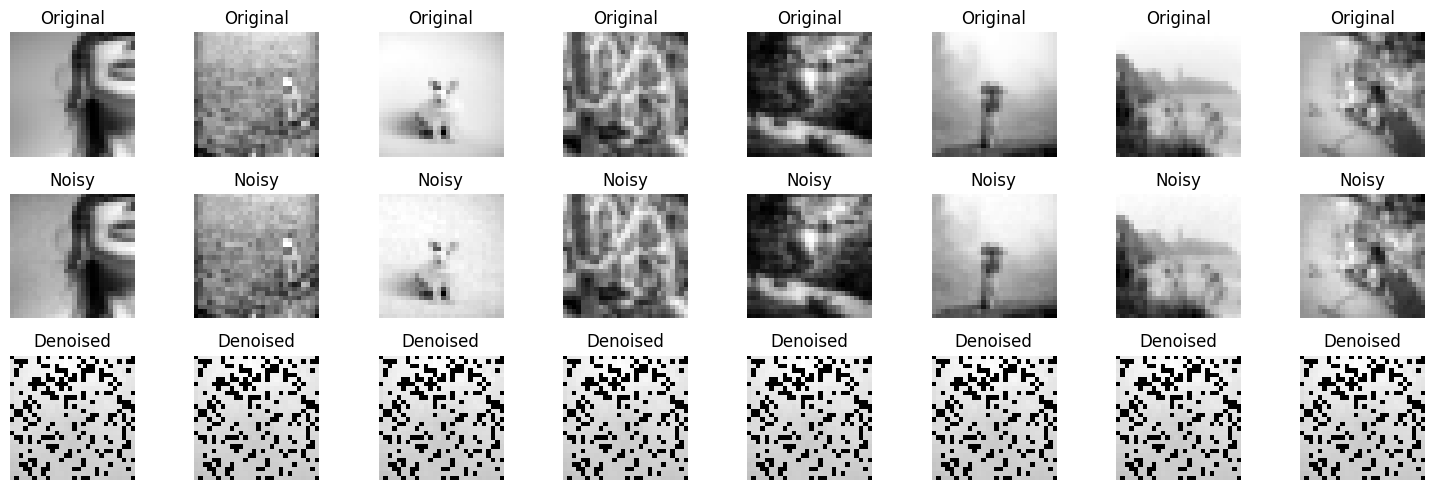

In [ ]:
show_denoising_results(autoencoder, val_loader, device)

# **8. Finetune**



## **8.1 Prepare dataset**


In [ ]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.45MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train size: 54000
Validation size: 6000
Test size: 10000


## **8.2 Build MLP network**




In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)

        return out

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10

mlp = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(mlp.parameters(), lr=lr)

**Transfer the Autoencoder weights to the MLP**

In [ ]:
mlp.layer1.weight.data = autoencoder.encoder[0].weight.data.clone()
mlp.layer1.bias.data = autoencoder.encoder[0].bias.data.clone()

mlp.layer2.weight.data = autoencoder.encoder[2].weight.data.clone()
mlp.layer2.bias.data = autoencoder.encoder[2].bias.data.clone()

mlp.layer3.weight.data = autoencoder.encoder[4].weight.data.clone()
mlp.layer3.bias.data = autoencoder.encoder[4].bias.data.clone()

mlp.layer4.weight.data = autoencoder.encoder[6].weight.data.clone()
mlp.layer4.bias.data = autoencoder.encoder[6].bias.data.clone()

mlp.layer5.weight.data = autoencoder.encoder[8].weight.data.clone()
mlp.layer5.bias.data = autoencoder.encoder[8].bias.data.clone()

mlp.layer6.weight.data = autoencoder.encoder[10].weight.data.clone()
mlp.layer6.bias.data = autoencoder.encoder[10].bias.data.clone()

mlp.layer7.weight.data = autoencoder.encoder[12].weight.data.clone()
mlp.layer7.bias.data = autoencoder.encoder[12].bias.data.clone()

mlp.output.weight.data = autoencoder.encoder[14].weight.data.clone()
mlp.output.bias.data = autoencoder.encoder[14].bias.data.clone()


## **8.3 Training**

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    mlp.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = mlp(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    mlp.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = mlp(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3010, Train_Acc: 0.1139, Validation Loss: 1.2749, Val_Acc: 0.1820
EPOCH 2/100, Train_Loss: 1.9431, Train_Acc: 0.1882, Validation Loss: 1.1391, Val_Acc: 0.1952
EPOCH 3/100, Train_Loss: 1.7817, Train_Acc: 0.2828, Validation Loss: 0.9450, Val_Acc: 0.4407
EPOCH 4/100, Train_Loss: 1.3817, Train_Acc: 0.4810, Validation Loss: 0.7406, Val_Acc: 0.5418
EPOCH 5/100, Train_Loss: 1.1547, Train_Acc: 0.5589, Validation Loss: 0.6527, Val_Acc: 0.5813
EPOCH 6/100, Train_Loss: 1.0284, Train_Acc: 0.6002, Validation Loss: 0.5924, Val_Acc: 0.6115
EPOCH 7/100, Train_Loss: 0.9603, Train_Acc: 0.6164, Validation Loss: 0.5859, Val_Acc: 0.6058
EPOCH 8/100, Train_Loss: 0.9273, Train_Acc: 0.6288, Validation Loss: 0.5633, Val_Acc: 0.6212
EPOCH 9/100, Train_Loss: 0.8997, Train_Acc: 0.6472, Validation Loss: 0.5295, Val_Acc: 0.6787
EPOCH 10/100, Train_Loss: 0.7966, Train_Acc: 0.7122, Validation Loss: 0.4397, Val_Acc: 0.7158
EPOCH 11/100, Train_Loss: 0.7180, Train_Acc: 0.7263, Validation Loss:

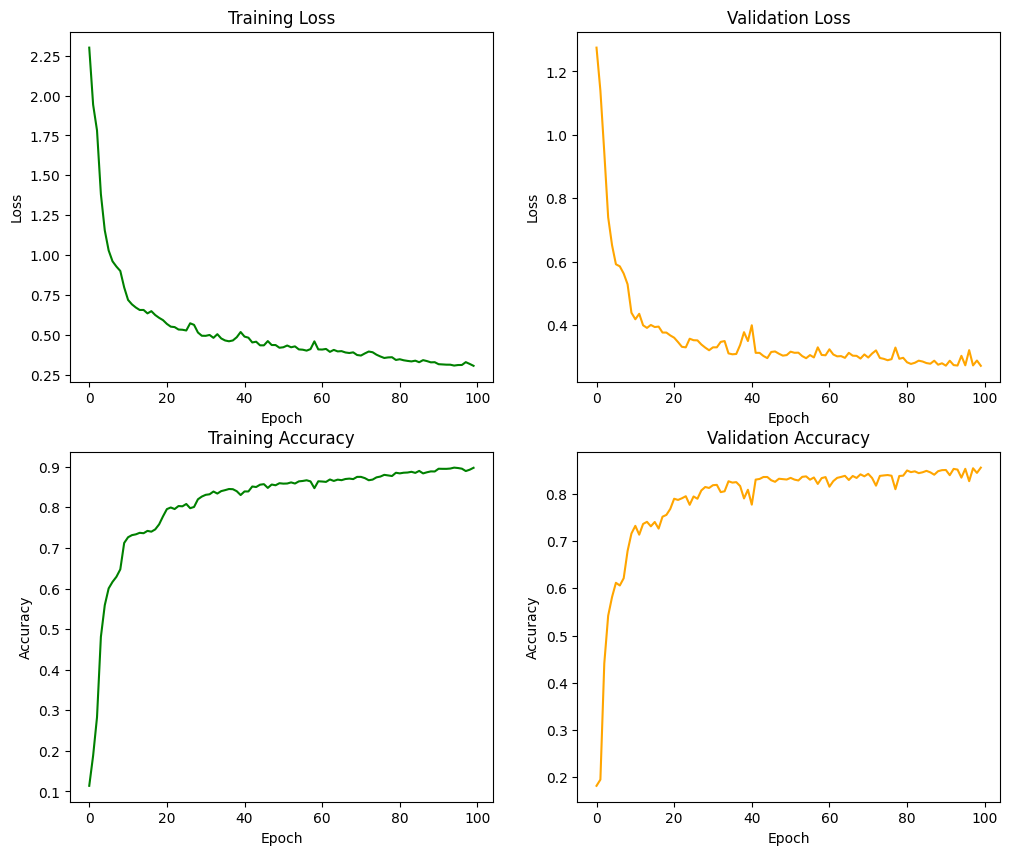

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **8.4 Evaluation**

In [ ]:
val_target = []
val_predict = []

mlp.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = mlp(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.8706666666666667


In [ ]:
test_target = []
test_predict = []

mlp.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = mlp(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8529
